# Для запуска в Google Colab

Раскомментируйте команды ниже для запуска в Colab. Код был протестирован с Python 3.8 и PyTorch 1.8 CUDA 11.

**После установки зависимостей необходим перезапуск окружения** 

In [1]:
# !apt install -y  git-lfs
# !git lfs version

In [2]:
# %cd /content

In [3]:
# !if [ ! -d ./made-adv-ml-hw2 ]; then git clone -b em-algo --depth 1 --single-branch https://github.com/KernelA/made-adv-ml-hw2.git; fi

In [4]:
# %cd /content/made-adv-ml-hw2

In [5]:
# !git lfs pull

In [6]:
# !pip install -r ./requirements.txt

In [7]:
# !if [ -f ./.dvc/tmp/rwlock ]; then rm ./.dvc/tmp/rwlock; fi

In [8]:
# !dvc repro train_test_split

In [9]:
import pathlib
import pickle
import shutil
import random

import numpy as np
import pandas as pd
from sklearn import preprocessing, linear_model
from scipy import sparse
from tqdm import tqdm
import torch

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

plt.style.use("bmh")
mpl.rcParams["figure.figsize"] = (8, 8)

In [10]:
np.random.seed(12)
random.seed(22)
torch.manual_seed(0)
torch.set_default_dtype(torch.float64)

In [11]:
%load_ext autoreload

%autoreload 2

In [12]:
from rating_model import TeamResults
from rating_model import PICKLE_PROTOCOL
from rating_model import EMRatingModel, get_player_skills, estimate_rank
from utils import load_pickle, dump_pickle, optimize_dataframe_numeric_dtypes

# 1 Предобработка данных

Основная логика предоработки данных содержится в .py файлах проекта.

In [13]:
tours_datapath = pathlib.Path("data", "pickle_data", "tournaments-dt.pickle")

In [14]:
tours = pd.read_pickle(tours_datapath)

In [15]:
players_datapath = pathlib.Path("data", "pickle_data", "players-dt.pickle")

In [16]:
players_info = pd.read_pickle(players_datapath)

In [17]:
team_res_datapath = pathlib.Path(
    "data", "team_res", "train_team_results.pickle")

In [18]:
team_res = load_pickle(team_res_datapath)

In [19]:
total_unknown_team_players = 0
total_unknown_answers = 0
for tour_id in team_res.tours:
    for team_id in team_res[tour_id]:
        team = team_res[tour_id][team_id]
        if not team.members:
            total_unknown_team_players += 1
        if not team.mask:
            total_unknown_answers += 1

In [20]:
print("Количество команд без состава команды: ", total_unknown_team_players,
      "Количество команд с неизвестными повопроснами результатами: ", total_unknown_answers, sep="\n")

Количество команд без состава команды: 
69
Количество команд с неизвестными повопроснами результатами: 
173


In [21]:
tours.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1105 entries, 4628 to 6485
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   name          1105 non-null   object             
 1   dateStart     1105 non-null   datetime64[ns, UTC]
 2   dateEnd       1105 non-null   datetime64[ns, UTC]
 3   type          1105 non-null   object             
 4   season        1015 non-null   object             
 5   orgcommittee  1105 non-null   object             
 6   synchData     669 non-null    object             
 7   questionQty   1105 non-null   object             
dtypes: datetime64[ns, UTC](2), object(6)
memory usage: 77.7+ KB


In [22]:
players_dump = pathlib.Path("dump", "players.pickle")
players_dump.parent.mkdir(exist_ok=True, parents=True)

In [23]:
force_get_players = False

In [24]:
players = None

In [25]:
if not players_dump.exists() or force_get_players:
    players = team_res.to_player_dataframe(filter_by_mask=True)
    optimize_dataframe_numeric_dtypes(players)
    dump_pickle(players_dump, players)
else:
    players = load_pickle(players_dump)

In [26]:
assert players.index.is_monotonic_increasing

In [27]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17823516 entries, 0 to 17823515
Data columns (total 5 columns):
 #   Column           Dtype
---  ------           -----
 0   tour_id          int16
 1   team_id          int32
 2   player_id        int32
 3   answer_id        int32
 4   is_right_answer  bool 
dtypes: bool(1), int16(1), int32(3)
memory usage: 255.0 MB


In [28]:
players.head()

,tour_id,team_id,player_id,answer_id,is_right_answer
0,4772,45556,6212,0,True
1,4772,45556,6212,1,True
2,4772,45556,6212,2,True
3,4772,45556,6212,3,True
4,4772,45556,6212,4,True


In [29]:
target = players["is_right_answer"].astype(np.int8).to_numpy()

## 2 Построение логистической регрессии для ранжирования игроков

Пусть параметры модели образуют составляют вектор $w = \left(s_1,s_2,\ldots,s_P, c_1, c_2, \ldots, c_A, b \right)^T,$ где $P-$ общее число игроков, $A-$ общее число вопросов. Таким образом значения параметров будут обозначать "силы игроков" $s_i, i=1,\ldots,P$ и сложнности вопросов $c_j, j=1,\ldots,A$, $b$- глоабальный коэффициент смещения/

Распредление ответов по всем игрокам:

<AxesSubplot:>

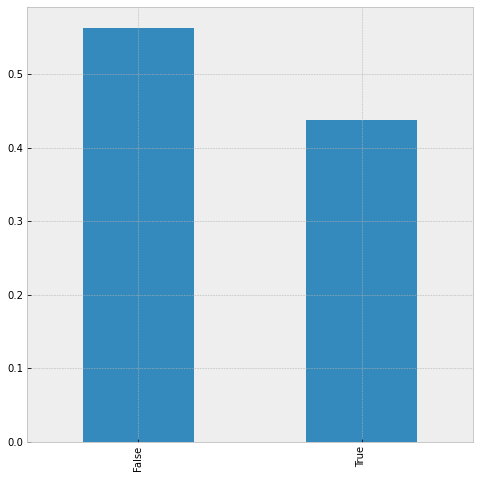

In [30]:
players["is_right_answer"].value_counts(normalize=True).plot.bar()

In [31]:
feature_dtype = np.float64

In [32]:
skils_encoder = preprocessing.OneHotEncoder(dtype=feature_dtype)

In [33]:
skils_features_one_hot = skils_encoder.fit_transform(
    players["player_id"].to_numpy().reshape(-1, 1))

In [34]:
questione_complex_encoder = preprocessing.OneHotEncoder(dtype=feature_dtype)

In [35]:
question_complices_one_hot = questione_complex_encoder.fit_transform(
    players["answer_id"].to_numpy().reshape(-1, 1))

In [36]:
features = sparse.hstack(
    (skils_features_one_hot, question_complices_one_hot), format="csr")
del skils_features_one_hot
del question_complices_one_hot

In [37]:
assert sparse.isspmatrix_csr(features)

In [38]:
features

<17823516x91209 sparse matrix of type '<class 'numpy.float64'>'
	with 35647032 stored elements in Compressed Sparse Row format>

In [39]:
dump_model_filepath = pathlib.Path("model", "log-reg")

In [40]:
dump_model_filepath.mkdir(parents=True, exist_ok=True)

In [41]:
force_train = False

In [42]:
model_dump = dump_model_filepath / "log-reg.pickle"

In [43]:
regression = None

In [44]:
if not force_train and model_dump.exists():
    regression = load_pickle(model_dump)

In [45]:
if regression is None:
    regression = linear_model.LogisticRegression(
        penalty="l1", C=1000, solver="liblinear", verbose=2, max_iter=25, fit_intercept=True)
    regression.fit(features, target)
    dump_pickle(model_dump, regression)

[LibLinear]

### Рейтинг игроков

Сравним позиции игроков на основе рейтингов с реальными позициями на момент [26 декабря 2019 (выгрузка содержит только первые 1000 записей)](https://rating.chgk.info/players.php?release=1429&surname=&name=&patronymic=&idplayer=28751&town=&search=%D0%98%D1%81%D0%BA%D0%B0%D1%82%D1%8C)

In [46]:
path_to_real_ratings = pathlib.Path(
    "data", "raw_data", "players-release-2019-12-26.csv")

In [47]:
top_n = 10

In [48]:
real_data = pd.read_csv(path_to_real_ratings, usecols=[
                        "id", "Место"], index_col="id", nrows=top_n)

In [49]:
player_ratings = get_player_skills(skils_encoder, regression.coef_[0])
player_ratings.sort_values("skill", inplace=True, ascending=False)

In [50]:
player_ratings[:top_n].join(real_data)

,skill,Место
27403,3.107026,5.0
4270,2.970318,6.0
28751,2.917373,2.0
27822,2.829079,3.0
30270,2.757737,4.0
40411,2.755631,NaN
30152,2.744717,1.0
38175,2.685589,NaN
20691,2.647100,NaN
199963,2.604934,NaN


В результате часть игроков, попавшие в топ из реального рейтинга совпали с результатом ранжирования после обучения логистической регрессии, но их позиции точно не совпали. Существуют игроки, которых не было в реальном рейтинге топ-1000. 

## 3 Оценка результатов

Для сравнение команд воспользуемся простым правилом. Для каждой команды в турнире возьмём игроков в отсортированном по убыванию "силе игроков" и отсортируем команды в лексикографическом порядке на основе значаений "силы".

In [51]:
test_team_res_datapath = pathlib.Path(
    "data", "team_res", "test_team_results.pickle")

In [52]:
team_res_test = load_pickle(test_team_res_datapath)

In [53]:
test_team_ratings = team_res_test.to_team_rating_by_tour()

In [54]:
test_team_ratings.head()

,tour_id,members,team_id,tour_rating
0,4957,"(30152, 30270, 27822, 28751, 27403, 4270)",49804,1.0
1,4957,"(34936, 40877, 25177, 113703, 33792, 107161)",4109,2.0
2,4957,"(33620, 21346, 13857, 46339, 37836, 19632)",3875,3.0
3,4957,"(32901, 28689, 19541, 13689, 9801, 18194)",77418,4.0
4,4957,"(6482, 34846, 36120, 32458, 25882, 30475)",2,5.5


### Коэффициент ранговой корреляции Кендалла и Спирмена 

In [55]:
baseline = estimate_rank(test_team_ratings, player_ratings)

In [56]:
print(*baseline.items(), sep="\n")

('Kendall', 0.60875620064822)
('Spearman', 0.7716014463677552)


In [57]:
del player_ratings

## 4 EM алгоритм

Рассмртрим ответы команды на вопросы. Если команда $t$ ответила на вопрос $q$, то это означает, что хотя бы один игрок ответил на вопрос. Если команда не ответила на вопрос, то это означает, что ни один игрок также не оветил на вопрос.

Таким образом введём скрытые переменные: $h_{i,q}$- игорок под номером $i$ ответил на вопрос $q$. Они связаны с $x_{t,q}$ следующим соотношением:
$$
x_{t,q} = 
\begin{cases}
0, \text{ то } h_{i,q} = 0 \text{ для всех игроков в команде } t,\\
1, \text{ то } \exists i \in t : h_{i,q}=1 \text{ т. е. хотя бы один игрока в команде } t \text{ ответил правильно}. 
\end{cases}
$$

Пусть распределение $h_{i,q}$ при условии "силы" игрока и сложности вопроса моделируется с помощью сигмоиды $p\left(h_{i,q} \vert s_i, c_q\right) \sim \sigma\left(b + s_i + c_q\right), s_i-$ сила игрока $i$, $c_q-$ сложность вопроса $q$, $b \in \mathbb{R}-$ глобальное смещение, $\sigma\left(\cdot\right)-$ сигмоида.

Рассмотрим итерацию EM-алгоритма для шага $m \geq 0$.

## E-шаг

$$
\mathrm{M} \left[ h^{(m+1)}_{i,q} \right] = 
\begin{cases}
0, \forall i \in t : x_{t,q} = 0,\\
p\left( h^{(m)}_{i,q} = 1 \vert \exists j \in t : h^{(m)}_{j,q} = 1\right) =
\dfrac{\sigma \left(b^{(m)} + s^{(m)}_i + c^{(m)}_q\right)}{1-\prod\limits_{k \in t} \left(1 - \sigma\left(b^{(m)} + s^{(m)}_k + c^{(m)}_q\right)\right)}, \text{ если } x_{t,q} = 1.
\end{cases}
$$

## М-шаг

Происходит обучение логистичексой регрессии при известных $\mathrm{M} \left[ h^{(m+1)}_{i,q} \right]$ и уточнение параметров:
$$
\mathrm{M} \left[ h^{(m+1)}_{i,q} \right] \sim \sigma\left(b^{(m+1)} + s^{(m+1)}_i + c^{(m+1)}_q\right)
$$

В качестве начального приближения параметров возьмём значения, полученные при обучении логистической регрессии.

In [58]:
coo_features = features.tocoo(copy=False)

In [59]:
coo_features

<17823516x91209 sparse matrix of type '<class 'numpy.float64'>'
	with 35647032 stored elements in COOrdinate format>

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [61]:
log_dir = pathlib.Path("em_train", "logs")
if log_dir.exists():
    shutil.rmtree(log_dir)
log_dir.mkdir(exist_ok=True, parents=True)

checkpoint_dir = pathlib.Path("em_train", "checkpoints")
if checkpoint_dir.exists():
    shutil.rmtree(checkpoint_dir)
checkpoint_dir.mkdir(exist_ok=True, parents=True)

em_model = EMRatingModel(em_num_iter=8, lr=1e-4,
                         log_reg_num_iter=5, device=device, log_dir=log_dir, checkpoint_dir=str(checkpoint_dir))

2021-04-06 02:09:34,786 INFO em_algo __init__ Will train logistic regression on cuda


In [62]:
metrics_history = em_model.fit(coo_features, target, players, skils_encoder,
                               test_team_ratings, baseline, regression.coef_, regression.intercept_)

2021-04-06 02:09:43,854 INFO em_algo _build_player_team_round_indices Building mask for zeroing hidden variables
2021-04-06 02:09:43,872 INFO em_algo _build_player_team_round_indices Use 100000 as base value for grouping


Train logistic regression: 100%|███████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.40it/s, Binary cross entropy=0.464, MAE=0.000208]


2021-04-06 02:10:35,616 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-06 02:10:35,617 INFO em_algo _validate Kendall +0.000010
2021-04-06 02:10:35,618 INFO em_algo _validate Spearman +0.000005
2021-04-06 02:10:35,619 INFO em_algo _validate Save model state to 'em_train\checkpoints\best_checkpoint.pt'
2021-04-06 02:10:35,670 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6087661923174588, 'Spearman': 0.7716068231659514}


Train logistic regression: 100%|███████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.43it/s, Binary cross entropy=0.464, MAE=0.000208]


2021-04-06 02:10:48,052 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-06 02:10:48,053 INFO em_algo _validate Kendall +0.000007
2021-04-06 02:10:48,055 INFO em_algo _validate Spearman +0.000006
2021-04-06 02:10:48,056 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-06 02:10:48,057 INFO em_algo _validate Kendall -0.000003
2021-04-06 02:10:48,058 INFO em_algo _validate Spearman +0.000001
2021-04-06 02:10:48,061 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6087633239381549, 'Spearman': 0.77160754860072}


Train logistic regression: 100%|███████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.43it/s, Binary cross entropy=0.464, MAE=0.000207]


2021-04-06 02:11:00,254 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-06 02:11:00,255 INFO em_algo _validate Kendall +0.000421
2021-04-06 02:11:00,257 INFO em_algo _validate Spearman +0.000560
2021-04-06 02:11:00,258 INFO em_algo _validate Save model state to 'em_train\checkpoints\best_checkpoint.pt'
2021-04-06 02:11:00,262 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-06 02:11:00,263 INFO em_algo _validate Kendall +0.000413
2021-04-06 02:11:00,264 INFO em_algo _validate Spearman +0.000554
2021-04-06 02:11:00,266 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6091767624284401, 'Spearman': 0.7721611985329285}


Train logistic regression: 100%|███████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.42it/s, Binary cross entropy=0.464, MAE=0.000207]


2021-04-06 02:11:12,395 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-06 02:11:12,396 INFO em_algo _validate Kendall +0.000422
2021-04-06 02:11:12,397 INFO em_algo _validate Spearman +0.000563
2021-04-06 02:11:12,399 INFO em_algo _validate Save model state to 'em_train\checkpoints\best_checkpoint.pt'
2021-04-06 02:11:12,402 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-06 02:11:12,403 INFO em_algo _validate Kendall +0.000002
2021-04-06 02:11:12,404 INFO em_algo _validate Spearman +0.000003
2021-04-06 02:11:12,406 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6091786380404252, 'Spearman': 0.7721644945218163}


Train logistic regression: 100%|███████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.42it/s, Binary cross entropy=0.464, MAE=0.000207]


2021-04-06 02:11:24,741 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-06 02:11:24,742 INFO em_algo _validate Kendall +0.000422
2021-04-06 02:11:24,743 INFO em_algo _validate Spearman +0.000565
2021-04-06 02:11:24,744 INFO em_algo _validate Save model state to 'em_train\checkpoints\best_checkpoint.pt'
2021-04-06 02:11:24,748 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-06 02:11:24,749 INFO em_algo _validate Kendall +0.000000
2021-04-06 02:11:24,750 INFO em_algo _validate Spearman +0.000002
2021-04-06 02:11:24,752 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6091786925656588, 'Spearman': 0.7721665679375652}


Train logistic regression: 100%|███████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.43it/s, Binary cross entropy=0.464, MAE=0.000207]


2021-04-06 02:11:37,366 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-06 02:11:37,367 INFO em_algo _validate Kendall +0.000420
2021-04-06 02:11:37,368 INFO em_algo _validate Spearman +0.000593
2021-04-06 02:11:37,369 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-06 02:11:37,369 INFO em_algo _validate Kendall -0.000002
2021-04-06 02:11:37,370 INFO em_algo _validate Spearman +0.000028
2021-04-06 02:11:37,372 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6091762641731152, 'Spearman': 0.7721944199898448}


Train logistic regression: 100%|███████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.42it/s, Binary cross entropy=0.464, MAE=0.000207]


2021-04-06 02:11:49,479 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-06 02:11:49,480 INFO em_algo _validate Kendall +0.000421
2021-04-06 02:11:49,480 INFO em_algo _validate Spearman +0.000593
2021-04-06 02:11:49,482 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-06 02:11:49,483 INFO em_algo _validate Kendall +0.000001
2021-04-06 02:11:49,484 INFO em_algo _validate Spearman +0.000000
2021-04-06 02:11:49,485 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6091770751029917, 'Spearman': 0.7721948046995829}


Train logistic regression: 100%|███████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.43it/s, Binary cross entropy=0.464, MAE=0.000207]


2021-04-06 02:12:01,675 INFO em_algo _validate Absolute difference relative to baseline:
2021-04-06 02:12:01,675 INFO em_algo _validate Kendall +0.000424
2021-04-06 02:12:01,676 INFO em_algo _validate Spearman +0.000597
2021-04-06 02:12:01,677 INFO em_algo _validate Save model state to 'em_train\checkpoints\best_checkpoint.pt'
2021-04-06 02:12:01,680 INFO em_algo _validate Absolute difference relative to previous params:
2021-04-06 02:12:01,682 INFO em_algo _validate Kendall +0.000003
2021-04-06 02:12:01,682 INFO em_algo _validate Spearman +0.000003
2021-04-06 02:12:01,683 INFO em_algo _validate Corr coefficients: {'Kendall': 0.6091798358697247, 'Spearman': 0.772198179855955}


M step: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:41<00:00, 12.67s/it]


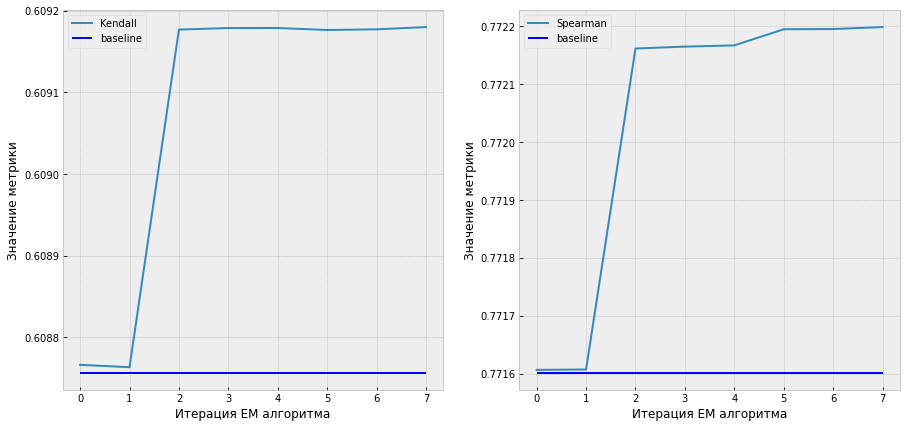

In [63]:
iterations = metrics_history["em_iter"]

fig = plt.figure(figsize=(15, 7))
axes = fig.subplots(1, len(metrics_history) - 1)
for ax_num, metric_name in enumerate(filter(lambda x: x != "em_iter", metrics_history)):
    axes[ax_num].plot(
        iterations, metrics_history[metric_name], label=metric_name)
    axes[ax_num].hlines(baseline[metric_name], 0, max(
        iterations), colors="blue", label="baseline")
    axes[ax_num].legend()
    axes[ax_num].set_xlabel("Итерация EM алгоритма")
    axes[ax_num].set_ylabel("Значение метрики")
    axes[ax_num].grid(True)

# 5 "Рейтинг-лист" турниров по сложности вопросов

In [86]:
weights = torch.load(em_model.best_checkpoint_file(), map_location="cpu")["lin_layer.weight"][0].numpy()

In [87]:
indices = len(skils_encoder.categories_[0]) + questione_complex_encoder.categories_[0]

In [88]:
question_complex = pd.DataFrame({"question_complex": weights[indices]}, index=questione_complex_encoder.categories_[0])
question_complex.index.name = "answer_id"

In [89]:
question_complex.head()

,question_complex
answer_id,
0,2.016682
1,1.053139
2,-0.548386
3,-0.183907
4,1.979798


In [116]:
def question_to_complex(questions_ids, question_complexices):
    return abs(question_complexices.loc[questions_ids, "question_complex"].mean())

In [117]:
tours_with_questios = players[["tour_id", "answer_id"]].groupby("tour_id").apply(lambda x: x["answer_id"].to_list())
tours_with_questios = tours_with_questios.apply(lambda x: question_to_complex(x, question_complex))

In [118]:
tours_with_questios.sort_values(ascending=False, inplace=True)

In [119]:
tours_with_questios.head()

tour_id
6149    13.397816
5717     4.772788
5963     4.338890
5930     4.084814
5438     3.724778
dtype: float64

In [120]:
target.shape

(17823516,)

In [121]:
top_n = 10

In [122]:
tours.loc[tours_with_questios.iloc[:top_n].index, ["name", "type"]]

,name,type
tour_id,,
6149,Чемпионат Санкт-Петербурга. Первая лига,"{'id': 2, 'name': 'Обычный'}"
5717,Чемпионат Таджикистана,"{'id': 2, 'name': 'Обычный'}"
5963,Асинхрон по South Park,"{'id': 8, 'name': 'Асинхрон'}"
5930,Зеркало мемориала памяти Михаила Басса,"{'id': 3, 'name': 'Синхрон'}"
5438,Синхрон Лиги Разума,"{'id': 3, 'name': 'Синхрон'}"
5427,День D,"{'id': 3, 'name': 'Синхрон'}"
6101,Воображаемый музей,"{'id': 3, 'name': 'Синхрон'}"
5532,Седьмая октава: Кубок Равноденствия. Лига Наци...,"{'id': 3, 'name': 'Синхрон'}"
5684,Синхрон высшей лиги Москвы,"{'id': 3, 'name': 'Синхрон'}"


In [123]:
tours.loc[tours_with_questios.iloc[-top_n:].index, ["name", "type"]]

,name,type
tour_id,,
5111,Открытый чемпионат Кипра,"{'id': 2, 'name': 'Обычный'}"
5544,Кубок Золотого Кольца России,"{'id': 2, 'name': 'Обычный'}"
5900,С берегов Оби,"{'id': 3, 'name': 'Синхрон'}"
6120,Открытый кубок МВУТ,"{'id': 2, 'name': 'Обычный'}"
5284,Гусарская лига. II сезон. III этап,"{'id': 8, 'name': 'Асинхрон'}"
6009,Синхронный турнир Mediterranean Cup,"{'id': 3, 'name': 'Синхрон'}"
6089,Чемпионат Абхазии,"{'id': 2, 'name': 'Обычный'}"
5433,Топ-1000,"{'id': 3, 'name': 'Синхрон'}"
5141,Азовский бриз,"{'id': 3, 'name': 'Синхрон'}"


Список турниров сло сложными вопросами получился не совсем интуитивный. В топе пристуствуют как чемпионаты, что ожидаемо так и более локальные соревнования. Возможно, на локальных соревнованиях совсем мало ответов или мало данных, по сравнению с шлобальными соревнованиями. Играют новички, которые плохо на данный момент отвечают на вопросы. В глобальных турнирах собираются команды профессионалов, которые уже имеют определённую подготовку.

Посмотрим на визуализацию ответов команда в этих ткрнирах.

In [124]:
def plot_tour(team_res, tours, tour_id):
    masks = []
    team_ids = []
    for team_id in team_res[tour_id]:
        masks.append(team_res[tour_id][team_id].mask)
        team_ids.append(team_id)
    try:
        fig = plt.figure(figsize=(60, 10))
        ax = fig.add_subplot(111)
        ax.imshow(masks, cmap="gray")
        ax.set_yticks(np.arange(len(team_ids)))
        ax.set_yticklabels(team_ids)
        ax.grid(False)
        ax.grid(True, axis="y")
        ax.set_ylabel("Номер команды")
        ax.set_title(tours.loc[tour_id, "name"])
    except TypeError:
        pass

## Самые сложные турниры

Виуализация отвеов на вопросы. Белый цвет означает, что команда ответила на вопрос. Чёрный что не ответила. 

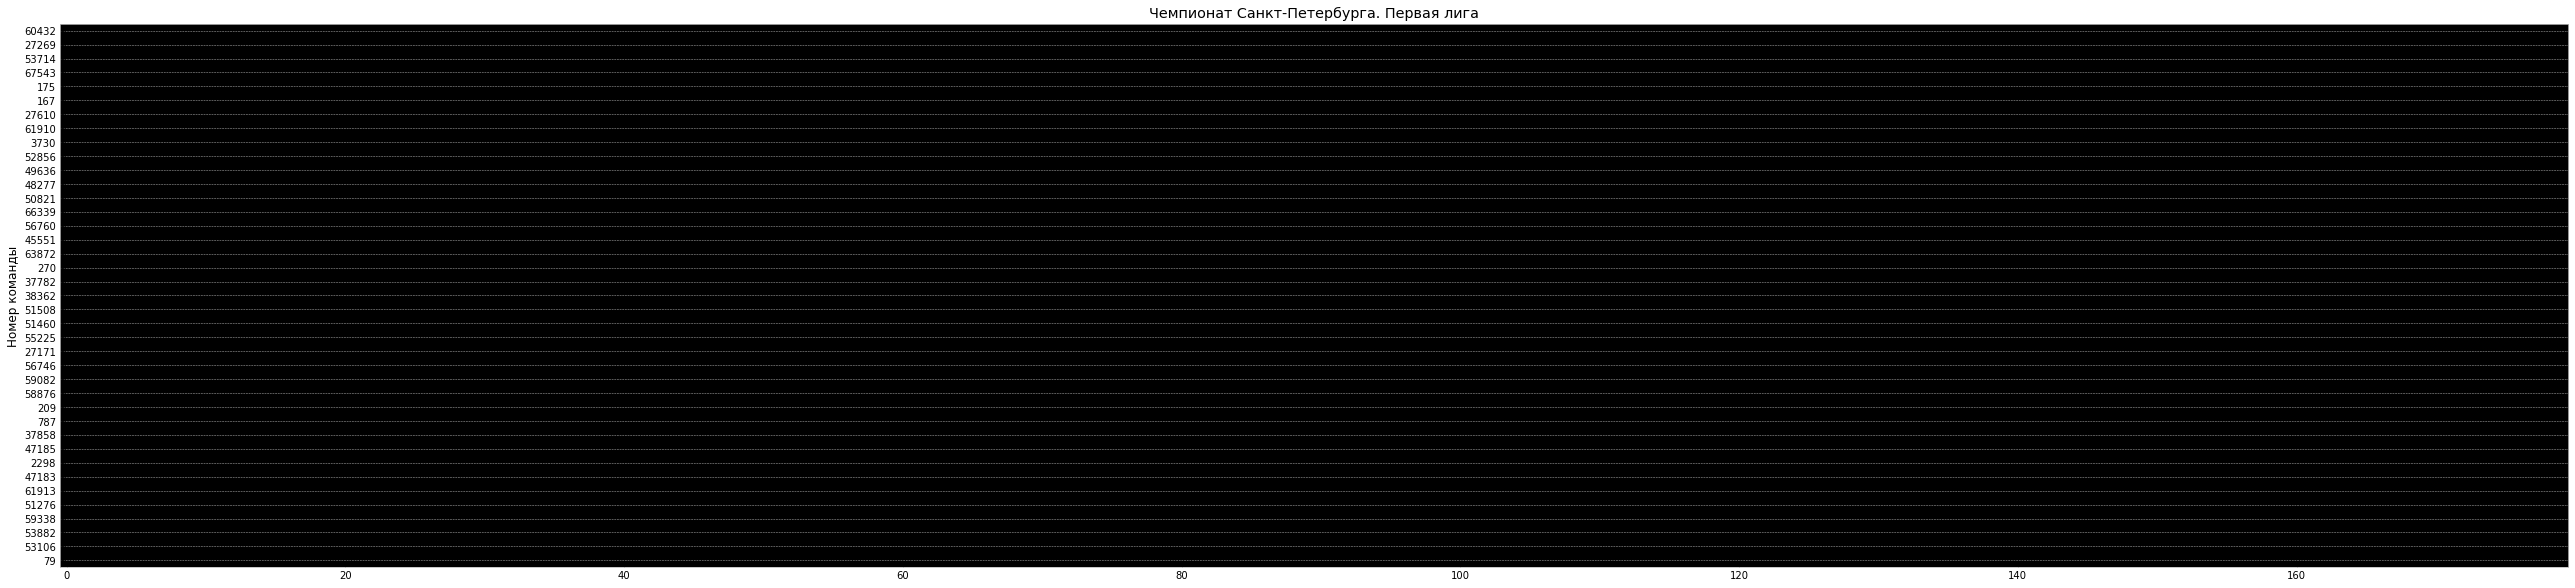

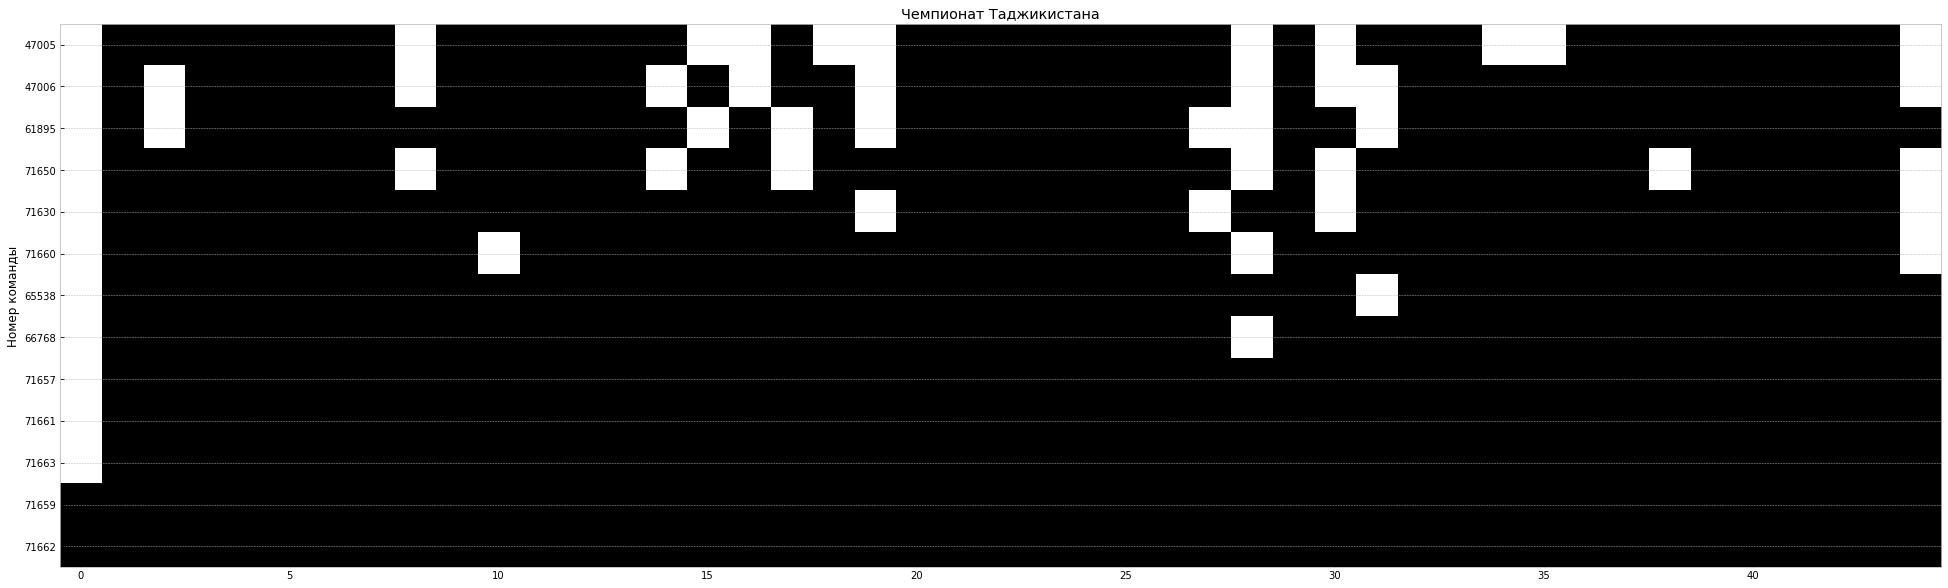

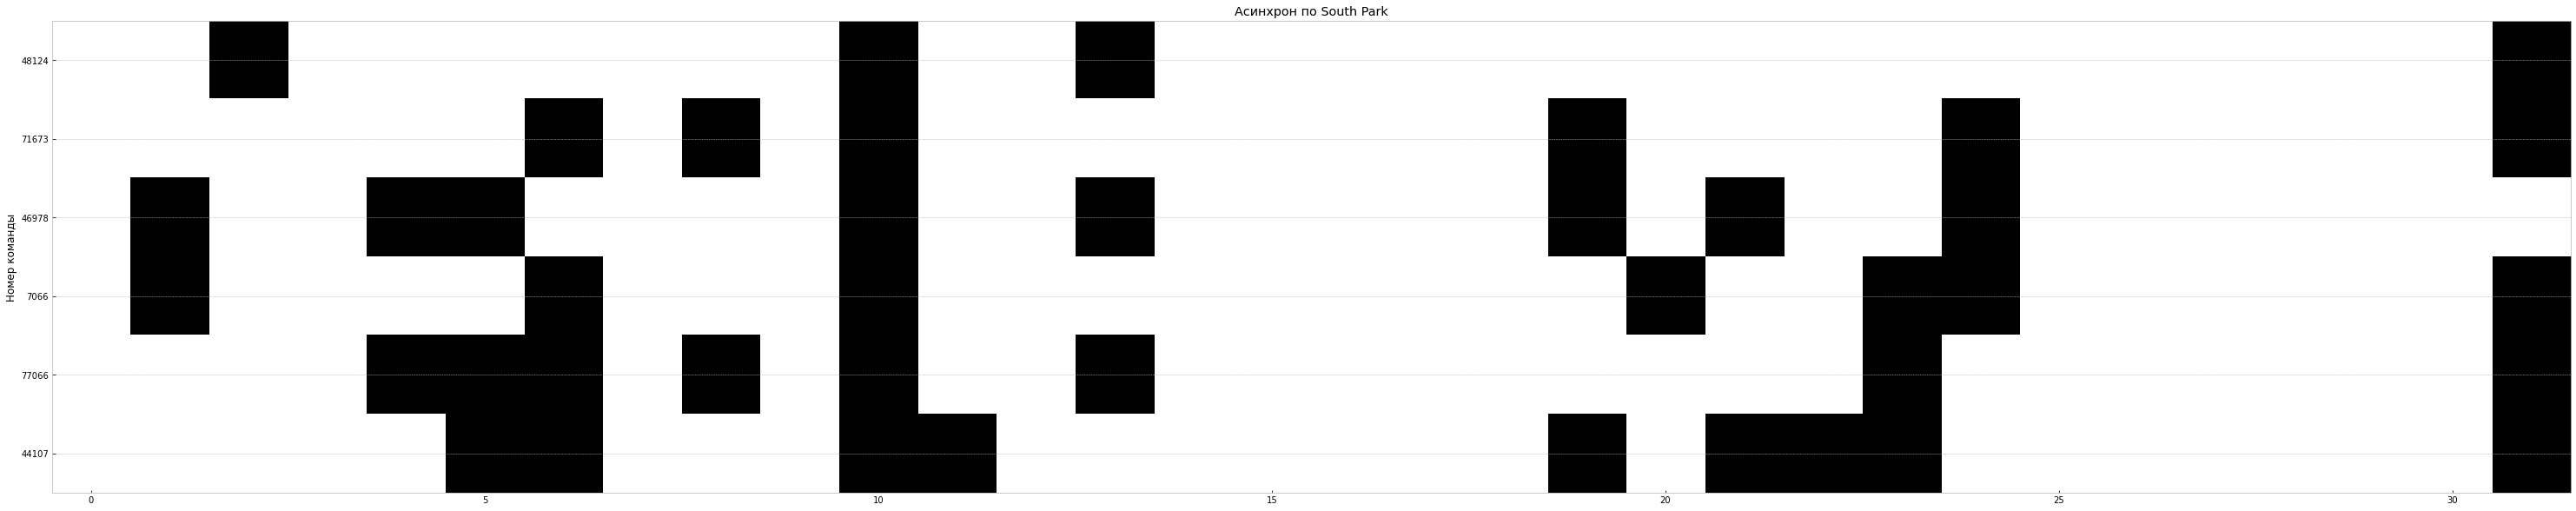

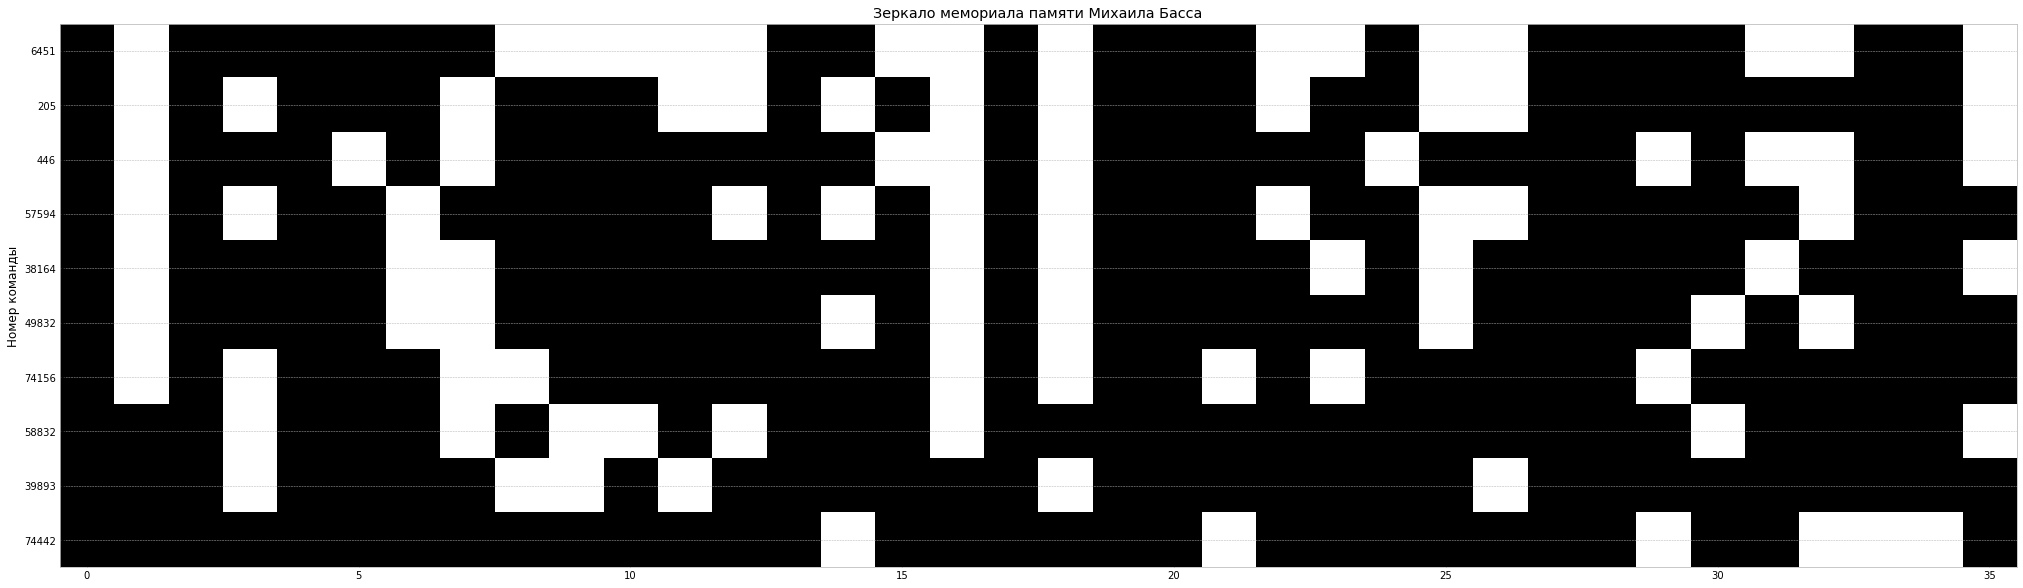

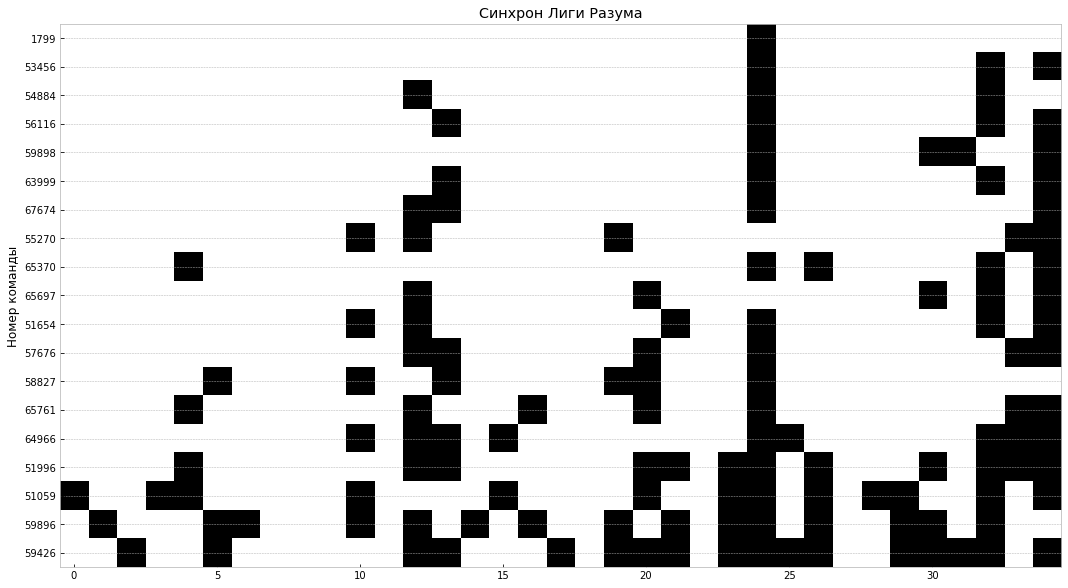

In [128]:
for tour_id in tours_with_questios.iloc[:5].index:
    plot_tour(team_res, tours, tour_id)

## Самые простые турниры

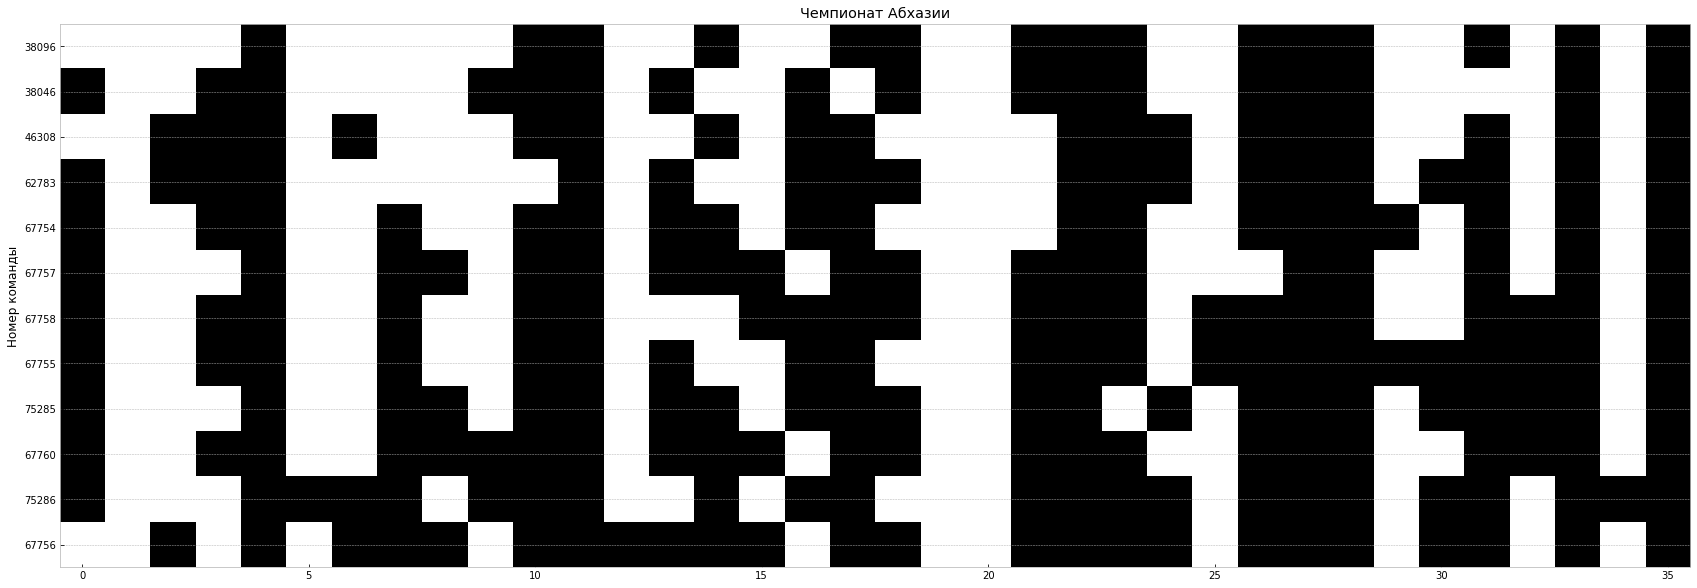

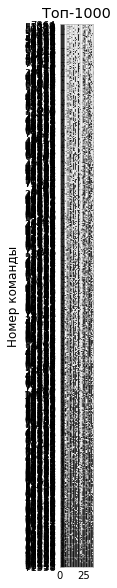

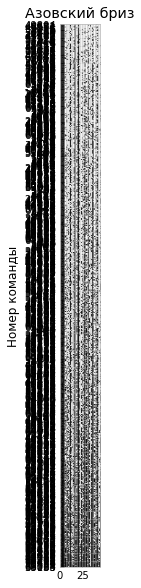

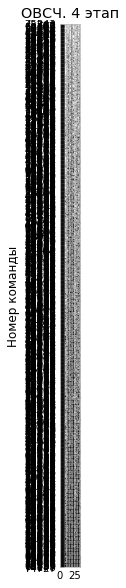

In [127]:
for tour_id in tours_with_questios.iloc[-4:].index:
    plot_tour(team_res, tours, tour_id)

# 6 Топ игроков

In [109]:
players.head()

,tour_id,team_id,player_id,answer_id,is_right_answer
0,4772,45556,6212,0,True
1,4772,45556,6212,1,True
2,4772,45556,6212,2,True
3,4772,45556,6212,3,True
4,4772,45556,6212,4,True


In [110]:
players_total_questions = players.groupby("player_id").agg(total_answers=("answer_id", "count"))

In [111]:
player_ratings = get_player_skills(skils_encoder, weights)

In [112]:
player_skill_quest = players_total_questions.join(player_ratings)
player_skill_quest.sort_values("skill", inplace=True, ascending=False)

In [113]:
top_n = 15

In [114]:
player_skill_quest.head(n=top_n)

,total_answers,skill
player_id,,
27403,2175,3.107518
4270,2689,2.970894
28751,3770,2.918127
27822,3210,2.829769
30270,3732,2.758514
40411,45,2.755655
30152,4845,2.745627
38175,36,2.685600
20691,1581,2.647542


<AxesSubplot:>

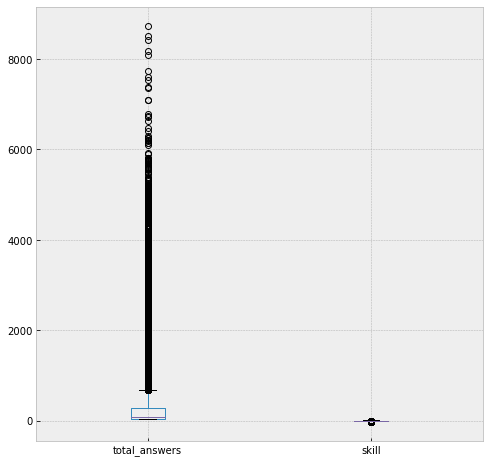

In [115]:
player_skill_quest.plot.box(by="total_answers")